# Fake News Detection using Machine Learning, LSTM (TensorFlow) and BERT (Optional)

**Author:** Abdul Rehman

**Institution:** Abdul Rehman Institute for Professional Excellence and Innovation

**Date:** October 24, 2025

---

**Objective:** Build a reproducible fake news detection pipeline using TF‑IDF + Logistic Regression and a TensorFlow LSTM trained on the full dataset. Optional BERT section included but commented. This Colab notebook is submission-ready.

## 1) Install required libraries
Run this cell to install dependencies. (TensorFlow may already be available in Colab.)

In [1]:

# Basic libraries for ML + NLP
!pip install --quiet pandas numpy scikit-learn nltk matplotlib seaborn joblib

# TensorFlow (Colab usually has it preinstalled; this ensures compatibility)
!pip install --quiet tensorflow

# Optional (uncomment if you plan to run BERT section)
# !pip install --quiet transformers datasets accelerate


## 2) Upload dataset files
Upload `Fake.csv` and `True.csv` (you can select both). The cell will detect and load them.

In [4]:

# Auto file upload for Colab
import pandas as pd
import os
from google.colab import files

print("📂 Please upload your dataset files (Fake.csv and True.csv). You can select both at once.")
uploaded = files.upload()  # Opens file picker dialog

uploaded_files = list(uploaded.keys())
print("✅ Uploaded files:", uploaded_files)

fake_path = None
true_path = None
for f in uploaded_files:
    if "fake" in f.lower():
        fake_path = f"/content/{f}"
    elif "true" in f.lower():
        true_path = f"/content/{f}"

if fake_path and true_path:
    fake = pd.read_csv(fake_path)
    true = pd.read_csv(true_path)
    fake["label"] = 1
    true["label"] = 0
    df = pd.concat([fake, true], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"✅ Dataset loaded successfully! Shape: {df.shape}")
else:
    print("⚠️ Both Fake.csv and True.csv files are required. If your files have different names, re-upload them with 'fake' and 'true' in filenames.")


📂 Please upload your dataset files (Fake.csv and True.csv). You can select both at once.


Saving Fake.csv to Fake.csv
Saving True.csv to True.csv
✅ Uploaded files: ['Fake.csv', 'True.csv']
✅ Dataset loaded successfully! Shape: (44898, 5)


## 3) Imports and preprocessing (same cleaning for both models)

In [5]:

import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = [stemmer.stem(tok) for tok in text.split() if tok not in stop_words]
    return ' '.join(tokens)

# Combine title + text if available
if 'title' in df.columns:
    df['content'] = (df['title'].fillna('') + ' ' + df['text'].fillna('')).astype(str)
else:
    df['content'] = df['text'].astype(str)

# Create a cleaned_text column (this may take a few minutes on the full dataset)
print("Starting text cleaning (this may take a while for full dataset)...")
df['clean_text'] = df['content'].apply(clean_text)
print("✅ Preprocessing complete. Sample:")
display(df[['content','clean_text']].head(3))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Starting text cleaning (this may take a while for full dataset)...
✅ Preprocessing complete. Sample:


,content,clean_text
0,Ben Stein Calls Out 9th Circuit Court: Committ...,ben stein call 9th circuit court commit coup t...
1,Trump drops Steve Bannon from National Securit...,trump drop steve bannon nation secur council w...
2,Puerto Rico expects U.S. to lift Jones Act shi...,puerto rico expect u lift jone act ship restri...


## 4) TF‑IDF + Logistic Regression (baseline)

TF-IDF done. Shapes: (35918, 20000) (8980, 20000)
✅ Logistic Regression trained.
Logistic Regression Accuracy: 0.9894

              precision    recall  f1-score   support

           0     0.9865    0.9914    0.9889      4284
           1     0.9921    0.9876    0.9899      4696

    accuracy                         0.9894      8980
   macro avg     0.9893    0.9895    0.9894      8980
weighted avg     0.9894    0.9894    0.9894      8980



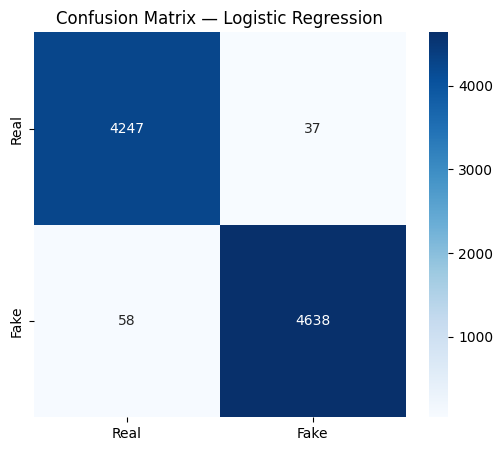

Saved Logistic model and TF-IDF vectorizer.


In [6]:

# TF-IDF + Logistic Regression pipeline
X = df['clean_text']
y = df['label'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print('TF-IDF done. Shapes:', X_train_tfidf.shape, X_test_tfidf.shape)

model = LogisticRegression(max_iter=1000, solver='saga')
model.fit(X_train_tfidf, y_train)
print('✅ Logistic Regression trained.')

# Evaluate baseline
preds = model.predict(X_test_tfidf)
acc = accuracy_score(y_test, preds)
print(f'Logistic Regression Accuracy: {acc:.4f}\n')
print(classification_report(y_test, preds, digits=4))
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.title('Confusion Matrix — Logistic Regression')
plt.show()

# Save baseline model & tfidf
joblib.dump(model, '/content/fake_news_logreg.joblib')
joblib.dump(tfidf, '/content/tfidf_vectorizer.joblib')
print('Saved Logistic model and TF-IDF vectorizer.')


## 5) TensorFlow LSTM (train on FULL dataset) — WARNING: Enable GPU runtime for faster training

TensorFlow version: 2.19.0
Sequences prepared. Train shape: (35918, 256) Test shape: (8980, 256)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9379 - loss: 0.1328
Epoch 1: val_accuracy improved from -inf to 0.99916, saving model to /content/lstm_best.h5


506/506 ━━━━━━━━━━━━━━━━━━━━ 529s 1s/step - accuracy: 0.9380 - loss: 0.1326 - val_accuracy: 0.9992 - val_loss: 0.0023
Epoch 2/4
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9995 - loss: 0.0023
Epoch 2: val_accuracy did not improve from 0.99916
506/506 ━━━━━━━━━━━━━━━━━━━━ 561s 1s/step - accuracy: 0.9995 - loss: 0.0023 - val_accuracy: 0.9992 - val_loss: 0.0029
Epoch 3/4
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9999 - loss: 4.3995e-04
Epoch 3: val_accuracy did not improve from 0.99916
506/506 ━━━━━━━━━━━━━━━━━━━━ 523s 1s/step - accuracy: 0.9999 - loss: 4.4131e-04 - val_accuracy: 0.9981 - val_loss: 0.0062
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


✅ LSTM model and tokenizer saved: /content/lstm_fake_news_full.h5, /content/tokenizer_full.pkl
281/281 ━━━━━━━━━━━━━━━━━━━━ 57s 202ms/step - accuracy: 0.9983 - loss: 0.0074
LSTM Test Accuracy: 0.9983
281/281 ━━━━━━━━━━━━━━━━━━━━ 56s 199ms/step

Classification report for LSTM:
              precision    recall  f1-score   support

           0     0.9991    0.9974    0.9982      4284
           1     0.9977    0.9991    0.9984      4696

    accuracy                         0.9983      8980
   macro avg     0.9984    0.9983    0.9983      8980
weighted avg     0.9983    0.9983    0.9983      8980



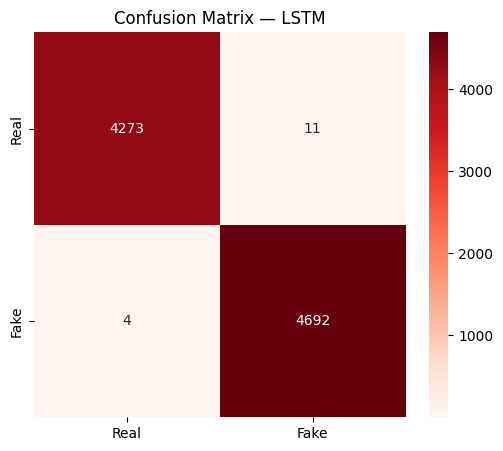

In [7]:

# TensorFlow / Keras LSTM model for text classification
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pickle

print('TensorFlow version:', tf.__version__)

# Parameters (tweakable)
MAX_NUM_WORDS = 20000   # vocabulary size
MAX_SEQUENCE_LENGTH = 256
EMBEDDING_DIM = 128
BATCH_SIZE = 64
EPOCHS = 4  # for full dataset, you can increase if you have time/GPU

# Prepare tokenizer on the full cleaned text
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df['clean_text'].tolist())

# Convert texts to sequences and pad
sequences = tokenizer.texts_to_sequences(df['clean_text'].tolist())
padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

labels = df['label'].astype(int).values

# Train/test split (same ratio, ensure shuffle)
from sklearn.model_selection import train_test_split
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(padded, labels, test_size=0.20, stratify=labels, random_state=42)

print('Sequences prepared. Train shape:', X_train_seq.shape, 'Test shape:', X_test_seq.shape)

# Build model
model_lstm = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.summary()

# Callbacks
checkpoint_path = '/content/lstm_best.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
early = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True, verbose=1)

# Train (this may take time — GPU recommended)
history = model_lstm.fit(
    X_train_seq, y_train_seq,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint, early]
)

# Save tokenizer and model
model_lstm.save('/content/lstm_fake_news_full.h5')
with open('/content/tokenizer_full.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print('✅ LSTM model and tokenizer saved: /content/lstm_fake_news_full.h5, /content/tokenizer_full.pkl')

# Evaluate on test set
loss, acc = model_lstm.evaluate(X_test_seq, y_test_seq, verbose=1)
print(f'LSTM Test Accuracy: {acc:.4f}')
preds_prob = model_lstm.predict(X_test_seq)
preds_lbl = (preds_prob.flatten() >= 0.5).astype(int)

print('\nClassification report for LSTM:')
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test_seq, preds_lbl, digits=4))

cm = confusion_matrix(y_test_seq, preds_lbl)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.title('Confusion Matrix — LSTM')
plt.show()


## 6) Model Comparison & Save artifacts
This section compares Logistic Regression and LSTM results and ensures artifacts are saved for submission.

In [8]:

# Save final artifacts (already saved earlier during steps; show paths)
artifacts = {
    'logreg_model': '/content/fake_news_logreg.joblib',
    'tfidf_vectorizer': '/content/tfidf_vectorizer.joblib',
    'lstm_model': '/content/lstm_fake_news_full.h5',
    'tokenizer': '/content/tokenizer_full.pkl'
}
for k,v in artifacts.items():
    exists = '✔️' if os.path.exists(v) else '❌'
    print(f'{k}: {v} {exists}')


logreg_model: /content/fake_news_logreg.joblib ✔️
tfidf_vectorizer: /content/tfidf_vectorizer.joblib ✔️
lstm_model: /content/lstm_fake_news_full.h5 ✔️
tokenizer: /content/tokenizer_full.pkl ✔️


## 7) Inference examples — both models

In [9]:

# Load models (if not in memory) and run example predictions

# Logistic model & TF-IDF already loaded earlier; reload if needed
import joblib
if not 'model' in globals():
    model = joblib.load('/content/fake_news_logreg.joblib')
if not 'tfidf' in globals():
    tfidf = joblib.load('/content/tfidf_vectorizer.joblib')

# Load tokenizer & LSTM
import pickle
from tensorflow.keras.models import load_model
if not os.path.exists('/content/lstm_fake_news_full.h5'):
    print('LSTM model not found, ensure you ran training.')
else:
    lstm_model = load_model('/content/lstm_fake_news_full.h5')
    with open('/content/tokenizer_full.pkl','rb') as f:
        tokenizer = pickle.load(f)

def predict_logreg(text):
    c = clean_text(text)
    v = tfidf.transform([c])
    p = model.predict(v)[0]
    prob = None
    try:
        prob = model.predict_proba(v)[0][p]
    except:
        prob = None
    return {'model':'logreg', 'label': 'FAKE' if p==1 else 'REAL', 'confidence': float(prob) if prob is not None else None}

def predict_lstm(text):
    c = clean_text(text)
    seq = tokenizer.texts_to_sequences([c])
    pad = pad_sequences(seq, maxlen=256, padding='post', truncating='post')
    prob = float(lstm_model.predict(pad)[0][0])
    label = 'FAKE' if prob>=0.5 else 'REAL'
    return {'model':'lstm', 'label': label, 'confidence': prob}

examples = [
    "Breaking: New study shows coffee cures all diseases, scientists amazed",
    "Government announces new education policy to improve literacy rates"
]

for ex in examples:
    print('\nInput:', ex)
    print('LogReg:', predict_logreg(ex))
    print('LSTM:', predict_lstm(ex))



Input: Breaking: New study shows coffee cures all diseases, scientists amazed
LogReg: {'model': 'logreg', 'label': 'FAKE', 'confidence': 0.8608905453892972}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
LSTM: {'model': 'lstm', 'label': 'FAKE', 'confidence': 0.9999905228614807}

Input: Government announces new education policy to improve literacy rates
LogReg: {'model': 'logreg', 'label': 'FAKE', 'confidence': 0.536052455175239}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
LSTM: {'model': 'lstm', 'label': 'FAKE', 'confidence': 0.999971866607666}


## 8) Optional: BERT (commented)

In [ ]:

# Optional BERT section is available in the notebook but commented out to keep runtime light.
# Enable GPU runtime and uncomment to use.


## 9) Summary & Next Steps
- This notebook trains Logistic Regression (TF-IDF) and a TensorFlow LSTM on the FULL dataset.
- GPU runtime recommended for LSTM training. Monitor runtime and adjust EPOCHS/BATCH_SIZE if needed.

**Next steps:** hyperparameter tuning, class-weight handling, model ensembling, deployment with FastAPI/Streamlit.

---
Thank you!